In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [3]:
class AstronomicalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.classes = sorted([d for d in os.listdir(root_dir) 
                               if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.images = []
        self.labels = []
        skipped = 0
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    skipped += 1
                    continue
                
                img_path = os.path.join(class_path, img_name)
                
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                    self.images.append(img_path)
                    self.labels.append(self.class_to_idx[class_name])
                except (IOError, SyntaxError, UnidentifiedImageError):
                    skipped += 1
                    pass
        
        print(f"Loaded {len(self.images)} valid images (skipped {skipped} invalid files)")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception:
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_root = '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam'


full_dataset = AstronomicalDataset(root_dir=dataset_root, transform=None)

print(f"Classes: {full_dataset.classes}")
print(f"Total images: {len(full_dataset)}")

Loaded 11448 valid images (skipped 1376 invalid files)
Classes: ['asteroid', 'black hole', 'comet', 'constellation', 'galaxy', 'nebula', 'planet', 'star']
Total images: 11448


In [5]:

torch.manual_seed(42)
subset_size = 1000  
subset_indices = torch.randperm(len(full_dataset))[:subset_size]
base_dataset = Subset(full_dataset, subset_indices)


train_size = int(0.8 * len(base_dataset))
val_size = len(base_dataset) - train_size
train_dataset, val_dataset = random_split(base_dataset, [train_size, val_size])



In [6]:
torch.manual_seed(42)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset_base, val_dataset_base = random_split(full_dataset, [train_size, val_size])


train_dataset = Subset(full_dataset, train_dataset_base.indices)
train_dataset.dataset.transform = train_transform  

val_dataset = Subset(full_dataset, val_dataset_base.indices)
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("Enhanced DataLoaders ready!")

Enhanced DataLoaders ready!


Batch shape: torch.Size([64, 3, 224, 224])


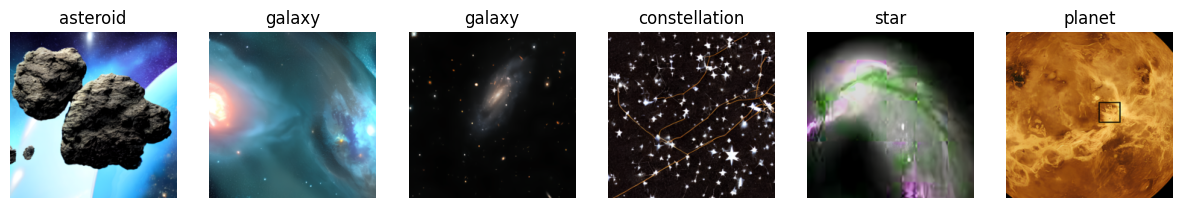

In [7]:

def denormalize(img):
    img = img.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    return img.clamp(0, 1)


images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")

fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(full_dataset.classes[labels[i]])
    axes[i].axis('off')
plt.show()

In [8]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        for param in self.base_model.parameters():
            param.requires_grad = False
        for param in self.base_model.layer4.parameters():
            param.requires_grad = True
        
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.base_model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(full_dataset.classes)
model = EnhancedCNN(num_classes=num_classes).to(device)
print(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 171MB/s] 


EnhancedCNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [9]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

print("Optimizer and scheduler ready!")

Optimizer and scheduler ready!


Epoch [1/5] | Loss: 1.0620 | Val Acc: 80.09%
Epoch [2/5] | Loss: 0.8069 | Val Acc: 81.31%
Epoch [3/5] | Loss: 0.7197 | Val Acc: 80.09%
Epoch [4/5] | Loss: 0.6437 | Val Acc: 81.79%
Epoch [5/5] | Loss: 0.5988 | Val Acc: 81.88%


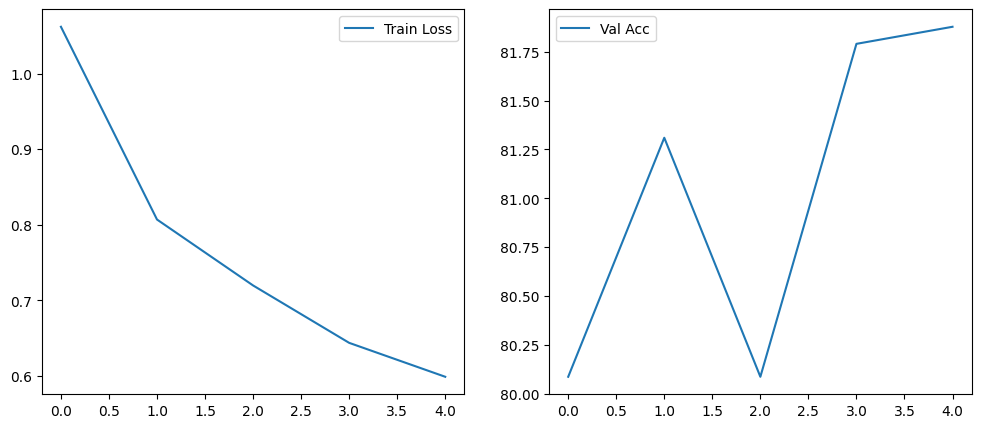

In [10]:
num_epochs = 5

train_losses = []
val_accuracies = []
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    
    scheduler.step(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.show()

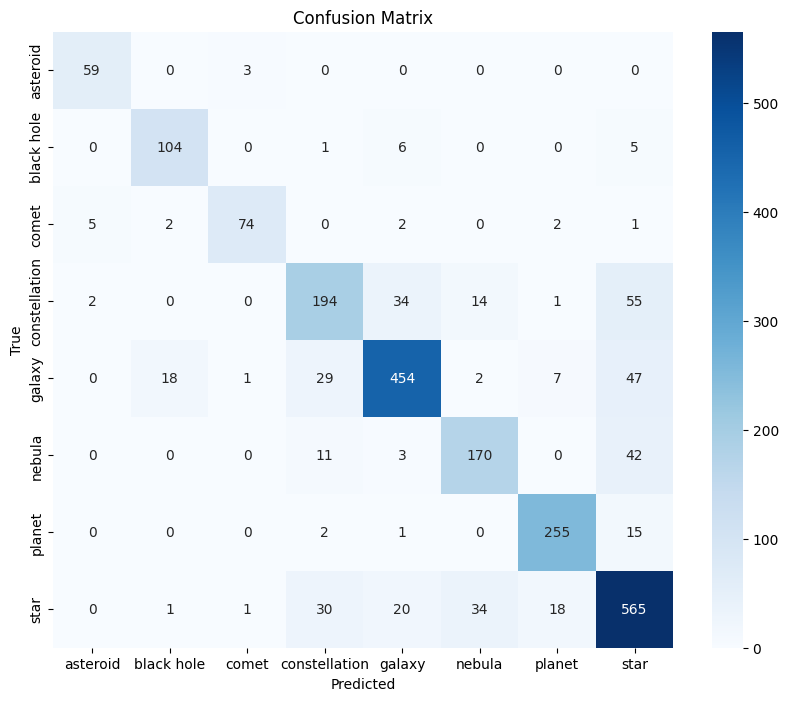

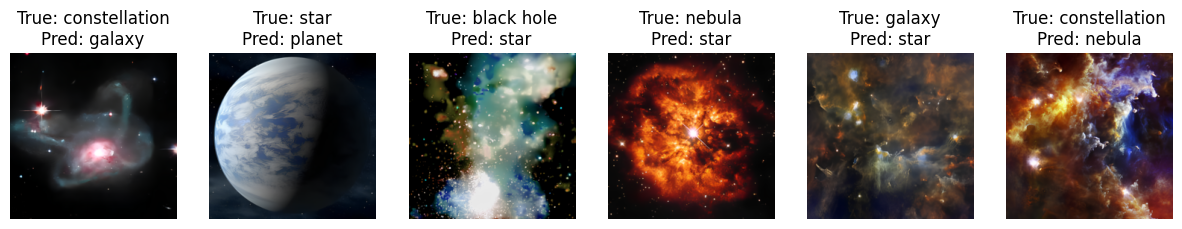

In [11]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

mis_idx = np.where(np.array(all_preds) != np.array(all_labels))[0]
if len(mis_idx) > 0:
    fig, axes = plt.subplots(1, min(6, len(mis_idx)), figsize=(15, 5))
    for i, idx in enumerate(mis_idx[:6]):
        img, true_label = val_dataset[idx]
        pred_label = all_preds[idx]
        img = denormalize(img).permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f"True: {full_dataset.classes[true_label]}\nPred: {full_dataset.classes[pred_label]}")
        axes[i].axis('off')
    plt.show()
else:
    print("No misclassifications in validation set!")

In [13]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

final_acc = 100 * correct / total
print(f"Final Validation Accuracy: {final_acc:.2f}%")

Final Validation Accuracy: 81.88%
